Authors: Pablo Soto and Martín Gómez


In [3]:
from random_forest import MyRandomForestRegressor

import numpy as np
import pandas as pd

from sklearn.datasets import (
    make_regression,
    make_friedman1,
    load_diabetes,
    fetch_california_housing
)
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import pickle


In [8]:
samples = [10, 25, 50, 100, 500, 1000]
friedman_1_datasets = [
    make_friedman1(
        n_samples=ns,
        n_features=20,
        noise=1.0,
        random_state=42
    ) for ns in samples]



In [9]:
models = {
    'RF_default': MyRandomForestRegressor(n_estimators=1000, max_depth=10, min_samples_split=2, n_features=20, bagging=True),
    #'RF_sklearn': RandomForestRegressor(n_estimators=100, max_depth=10, max_features=10),
    'RF_simple': MyRandomForestRegressor(n_estimators=1000, max_depth=10, min_samples_split=2, n_features=20, bagging=True, split_criterion="middle"),
}

In [4]:
friedman_1_probs = {}

for name, model in tqdm(models.items()):
    friedman_1_probs[name] = {}

    # Loop over the 6 datasets
    for idx, (X, y) in enumerate(friedman_1_datasets):
        # Fit the model on this dataset
        model.fit(X, y)
        
        probs = model.get_cut_probs()  # shape: (num_samples, num_indices)
        friedman_1_probs[name][idx] = probs


with open("friedman_1_probs.pkl", "wb") as file:
    pickle.dump(friedman_1_probs, file)


  0%|          | 0/2 [00:00<?, ?it/s]

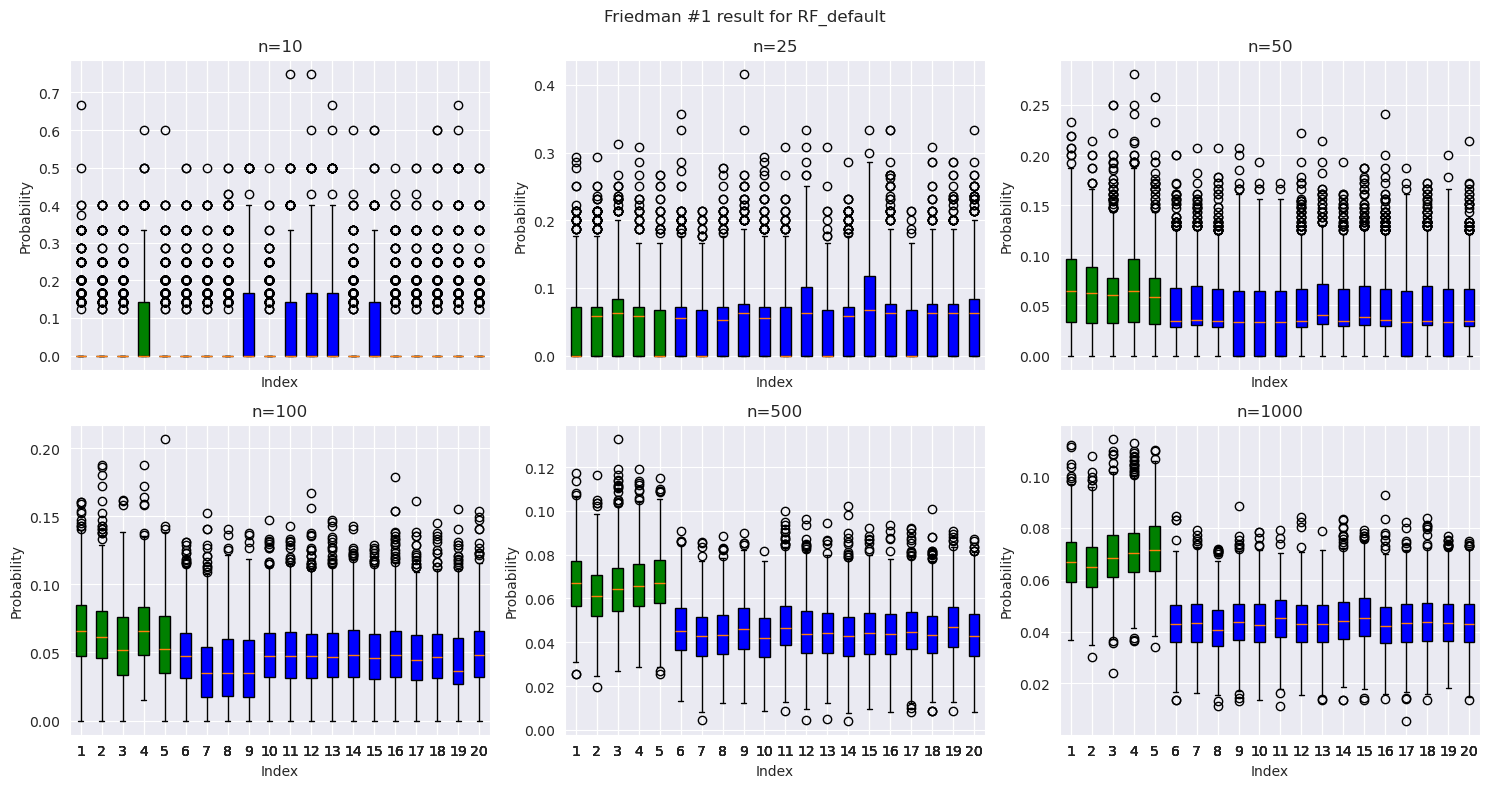

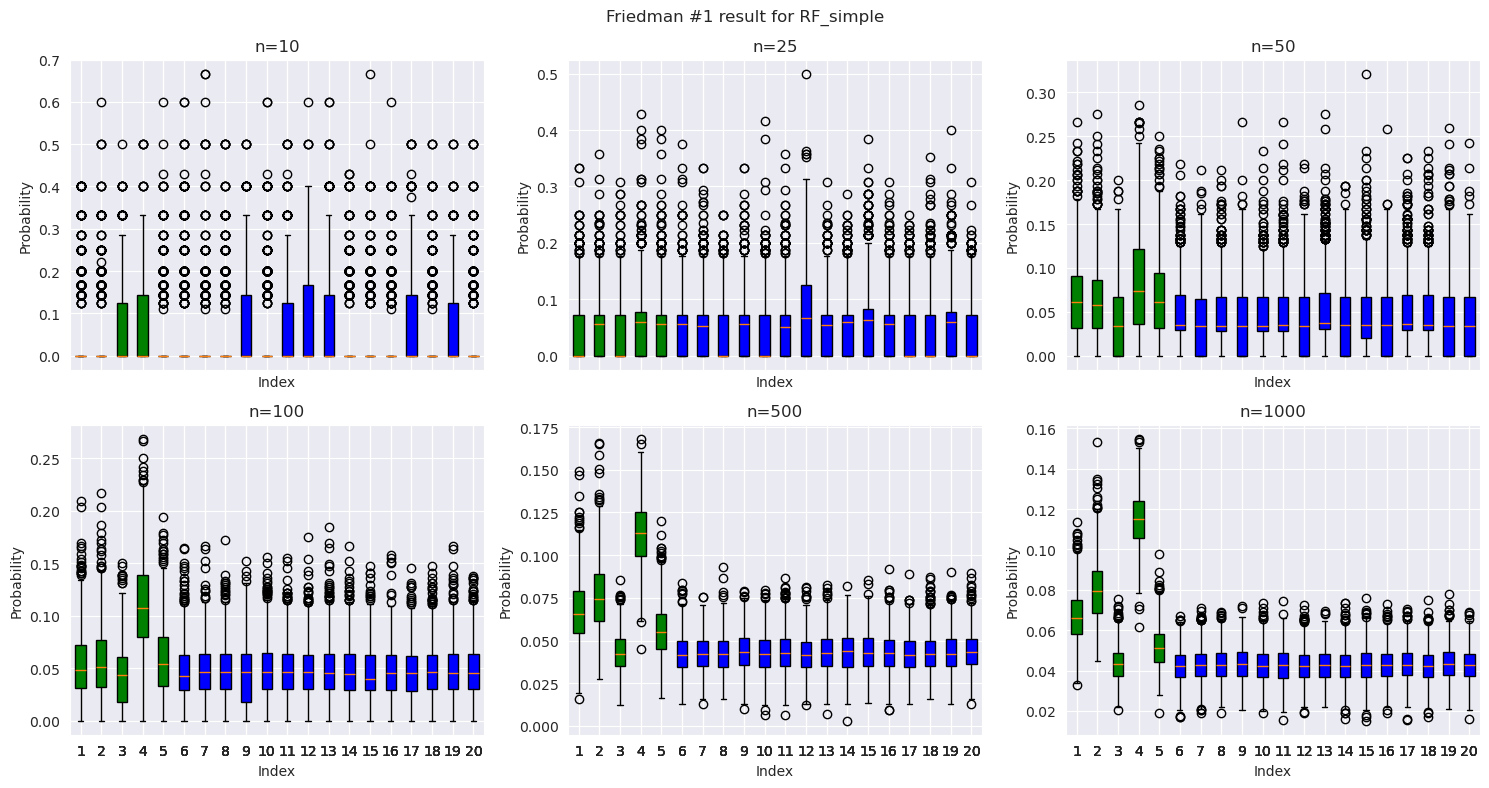

In [19]:
with open("friedman_1_probs.pkl", "rb") as file:
    friedman_1_probs = pickle.load(file)

# Define the colors for the two groups
first_color = "green"
second_color = "blue"

for name, p_dict in friedman_1_probs.items():
    fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True)
    axes = axes.ravel()  

    # Loop over the 6 datasets
    for idx, probs in p_dict.items():
        
        # Current axis
        ax = axes[idx]
        
        # Prepare data
        data = [probs[:, i] for i in range(probs.shape[1])]
        
        # Plot the boxplot for the current dataset
        box = ax.boxplot(
            data, 
            patch_artist=True  # Enables coloring the boxes
        )
        
        # Apply colors to the boxes
        for i, patch in enumerate(box['boxes']):
            if i < 5:
                patch.set_facecolor(first_color)
            else:
                patch.set_facecolor(second_color)
        
        # Set title and labels
        ax.set_title(f"n={samples[idx]}")
        ax.set_xlabel("Index")
        ax.set_ylabel("Probability")
    
    # Adjust layout and save/show the figure
    fig.suptitle(f"Friedman #1 result for {name}")
    plt.tight_layout()
    plt.savefig(f"img/friedman1_probs_{name}.png")
    plt.show()

In [6]:
cal_data = fetch_california_housing()
X_full, y_full = cal_data.data, cal_data.target
print("Full dataset shape:", X_full.shape)

np.random.seed(42)
idx = np.random.choice(X_full.shape[0], size=1000, replace=False)
X_sample = X_full[idx]
y_sample = y_full[idx]

print("Sampled dataset shape:", X_sample.shape)

# Add random noise features 
num_noise_features = 12
noise_features = np.random.randn(X_sample.shape[0], num_noise_features)
X_noisy = np.hstack([X_sample, noise_features])
print("X_noisy shape:", X_noisy.shape)

Full dataset shape: (20640, 8)
Sampled dataset shape: (1000, 8)
X_noisy shape: (1000, 20)


In [7]:
cal_datasets = []
for ns in samples:
    indices = np.random.choice(X_noisy.shape[0], size=ns, replace=False)
    cal_datasets.append((X_noisy[indices], y_sample[indices]))


In [8]:
cal_probs = {}

for name, model in tqdm(models.items()):
    cal_probs[name] = {}

    # Loop over the 6 datasets
    for idx, (X, y) in enumerate(tqdm(cal_datasets, leave=False)):
        # Fit the model on this dataset
        model.fit(X, y)
        probs = model.get_cut_probs()  # shape: (num_samples, num_indices)
        cal_probs[name][idx] = probs

with open("california_housing_probs.pkl", "wb") as file:
    pickle.dump(cal_probs, file)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

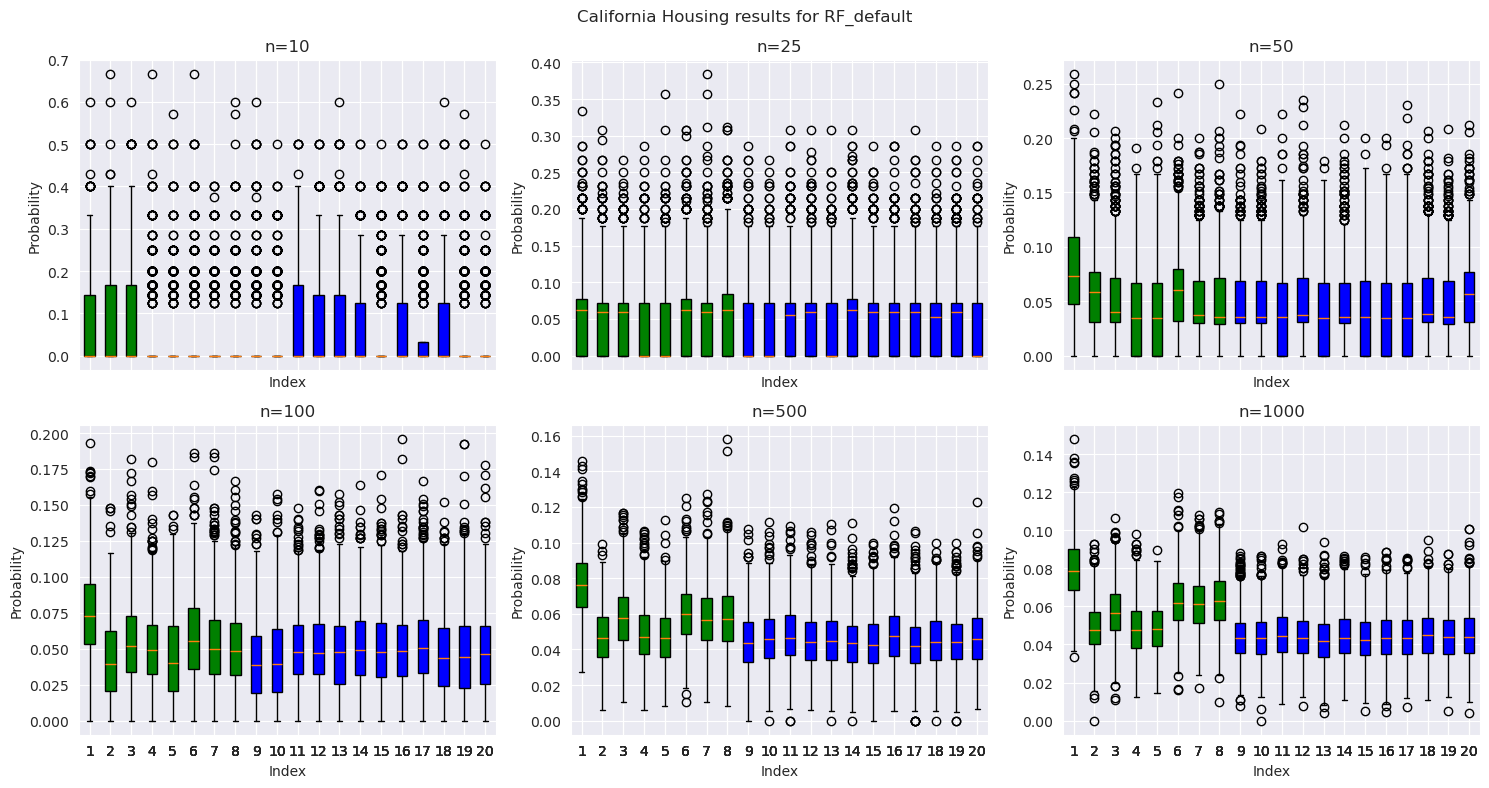

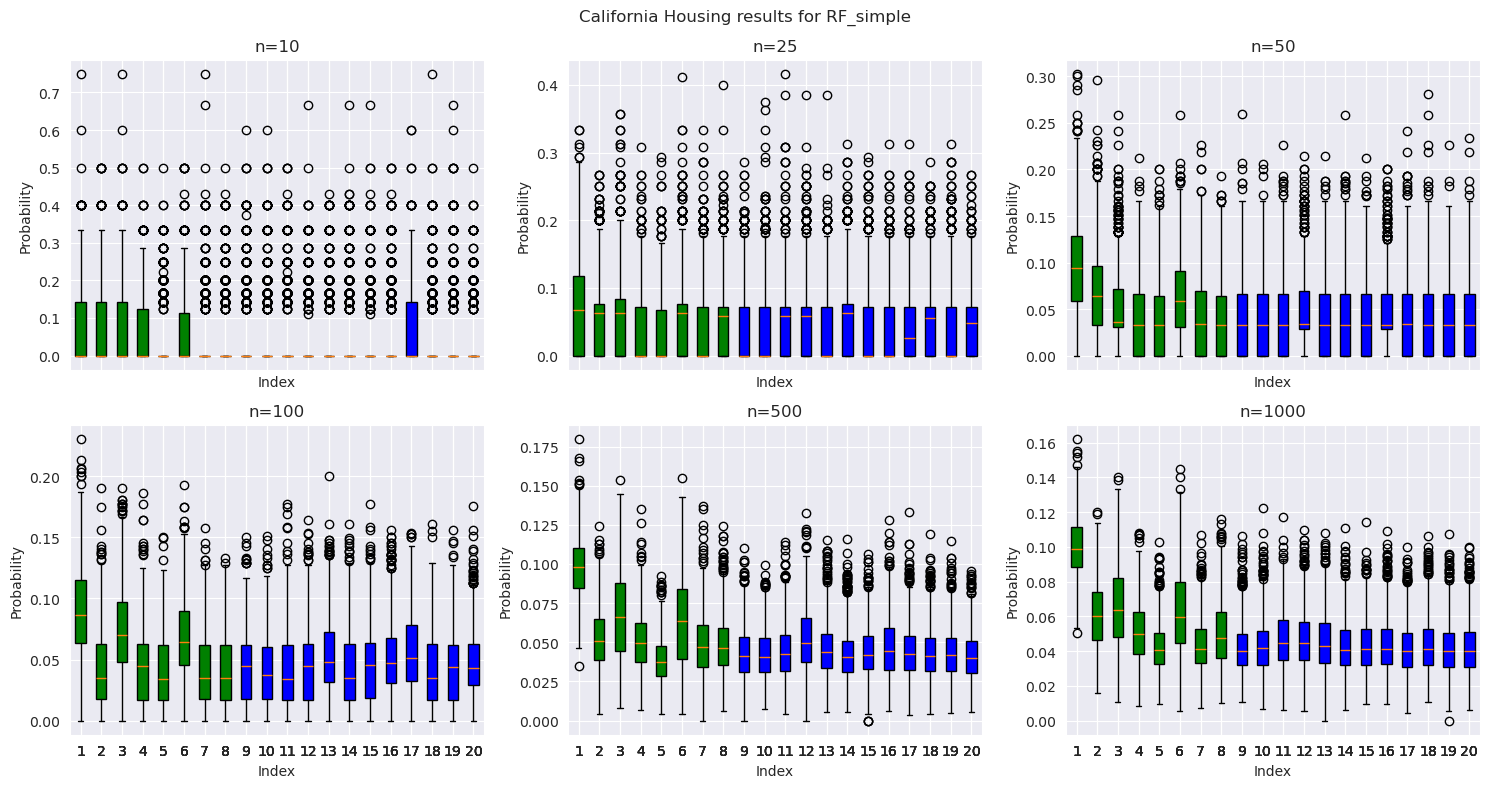

In [20]:
with open("california_housing_probs_10000.pkl", "rb") as file:
    cal_probs = pickle.load(file)

sns.set_style('darkgrid')

for name, p_dict in cal_probs.items():
    fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True)
    axes = axes.ravel()  

    # Loop over the 6 datasets
    for idx, probs in p_dict.items():
        
        # Current axis
        ax = axes[idx]
        
        #data = [probs[probs[:, i] <= 0.2, i] for i in range(probs.shape[1])]
        data = [probs[:, i] for i in range(probs.shape[1])]
        # Plot the boxplot for the current dataset
        box = ax.boxplot(
            data, 
            patch_artist=True
        )

        # Apply colors to the boxes
        for i, patch in enumerate(box['boxes']):
            if i < 8:
                patch.set_facecolor(first_color)
            else:
                patch.set_facecolor(second_color)
        
        # Set title and labels
        ax.set_title(f"n={samples[idx]}")
        ax.set_xlabel("Index")
        ax.set_ylabel("Probability")
        #ax.set_ylim(-0.01, 0.2)
    
    fig.suptitle(f"California Housing results for {name}")
    plt.tight_layout()
    plt.savefig(f"img/california_housing_probs_{name}.png")
    plt.show()